In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import set_config

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score, confusion_matrix

from performance import plot_roc, plot_learning_curves
from lcfunctions import load_lasair_lc, lasair_clean
from raw_processing import label_schemes

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight


/Users/aridmist/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Generate dataset

In [4]:
label_scheme = 'labels_1'

pd.options.display.max_columns = None
                     
dataset = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.csv')
dataset = label_schemes(dataset)

dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
dataset.columns

dwarf_nova_SU_UMa    572
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
dwarf_nova_WZ_Sge     58
int_polar             49
AMCVn                 46
nova                  46
Name: labels_1, dtype: int64


Index(['oid_ztf', 'oid_aavso', 'type_aavso', 'ra', 'dec', 'Eclipsing',
       'CV_Types', 'CV_subtypes', 'CV_subsubtypes', 'eclipse_clear',
       'manual_label', 'Clarity', 'labels_1', 'labels_2', 'labels_3',
       'labels_4'],
      dtype='object')

### Dictionary of light curve information

In [5]:
# Create a dictionary of dictionary, where each sub-dictionary contains the light curve data for a given object

def lightcurve_dictionary(dataset, lc_folder = '../lightcurves_dataset/lasair_2023_03_25'):

    lightcurves = {}
    for obj in dataset['oid_ztf']:
        print(obj)
        # Load and process lasair light curve, the split into g and r bands
        lc_test = load_lasair_lc(oid=obj, path=lc_folder)
        lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)
        df_lc = lc_appmag_test.copy()
        df_lc_g = df_lc[df_lc['fid'] == 1].reset_index(drop=True)
        df_lc_r = df_lc[df_lc['fid'] == 2].reset_index(drop=True)

        lightcurves[obj] = {'g_mag': df_lc_g['dc_mag'].values, 
                            'r_mag': df_lc_r['dc_mag'].values,
                            'g_jd': df_lc_g['jd'].values,
                            'r_jd': df_lc_r['jd'].values
                            }
    
    return lightcurves
    

lightcurves = lightcurve_dictionary(dataset)

ZTF18abryuah
ZTF18abtrvgp
ZTF17aaaehby
ZTF18abgjgiq
ZTF18abumlux
ZTF18absgnqy
ZTF18aaxdlbl
ZTF18absgzlu
ZTF18acegnyn
ZTF18aaadtna
ZTF18acywwfg
ZTF17aabxrtj
ZTF18aagqeuv
ZTF18aahmxsl
ZTF17aaarxou
ZTF17aaairkd
ZTF19aabiema
ZTF18acnnsmq
ZTF18abcrbmk
ZTF18admxenl
ZTF18abwiccd
ZTF18abwpsyj
ZTF18aaylcic
ZTF18aagrcve
ZTF20abragvw
ZTF19abhpnxh
ZTF18adlhiaq
ZTF18aazucqe
ZTF18abnbluc
ZTF18aajqtnw
ZTF18aapovzp
ZTF18aainbrb
ZTF18aauxwft
ZTF18aaxcqso
ZTF19abtsrif
ZTF18abuhqfi
ZTF19aakuyyr
ZTF17aacbuuj
ZTF17aadnfyi
ZTF20abbndvn
ZTF18aaldiqd
ZTF18aaojabr
ZTF18aabpzjg
ZTF18acviwua
ZTF18aalurkz
ZTF18acurptp
ZTF18acrxpcz
ZTF18aaqphee
ZTF17aaaizfe
ZTF18aaarims
ZTF17aaajlfw
ZTF17aabtvrf
ZTF19aakvlvn
ZTF19aapzvoj
ZTF18aaadlpa
ZTF17aaairls
ZTF18aaowqsq
ZTF18aalgarl
ZTF18aapobha
ZTF17aaagrxo
ZTF17aaaufmh
ZTF17aabskxk
ZTF18actbrbg
ZTF18acqxpha
ZTF19aaclwhr
ZTF18abttrrr
ZTF18abcoxgp
ZTF18abadsmu
ZTF18abuescl
ZTF18admesgz
ZTF18abccodq
ZTF18abcqzxh
ZTF18abotfmi
ZTF17aaabbhn
ZTF20acowhlb
ZTF17aacpvmc
ZTF19aayjhzx

### Functions for obtaining different input representations

In [6]:
from scipy.signal import find_peaks

def getdiffs(array):
    if len(array):
        diffs = np.diff(array)
        return diffs
    else:
        return np.array([])

def backfilled_magnitudes(lightcurves, n_pts=500, backfill_value=np.nan):
    X_gmag = np.empty((0, n_pts))
    X_rmag = np.empty((0, n_pts))
    X_gjd = np.empty((0, n_pts))
    X_rjd = np.empty((0, n_pts))

    for obj in lightcurves.keys():
        for key in ['g_mag', 'r_mag', 'g_jd', 'r_jd']:
            lc = lightcurves[obj][key]

            if key == 'g_jd' or key == 'r_jd':
                try:
                    lc = (lc - lc[0])
                except:
                    lc = []

            if len(lc) < n_pts:
                lc = np.pad(lc, (n_pts-len(lc), 0), 'constant', constant_values=(backfill_value, backfill_value))
            elif len(lc) >= n_pts:
                lc = lc[-n_pts:]
            
            if key == 'g_mag':
                X_gmag = np.vstack((X_gmag, lc))
            elif key == 'r_mag':
                X_rmag = np.vstack((X_rmag, lc))
            elif key == 'g_jd':
                X_gjd = np.vstack((X_gjd, lc))
            elif key == 'r_jd':
                X_rjd = np.vstack((X_rjd, lc))
            
    return X_gmag, X_rmag, X_gjd, X_rjd


def dmdt(lightcurves, n_pts=500, backfill_value=np.nan):

    X_gdm = np.empty((0, n_pts))
    X_gdt = np.empty((0, n_pts))
    X_rdm = np.empty((0, n_pts))
    X_rdt = np.empty((0, n_pts))

    for obj in lightcurves.keys():
        for key in ['g_mag', 'r_mag', 'g_jd', 'r_jd']:
            lc = lightcurves[obj][key]

            if len(lc) > 0:
                diff = np.diff(lc)
                diff = np.insert(diff, 0, 0)
            elif len(lc) == 0:
                diff = np.array([])
            
            if len(diff) < n_pts:
                diff = np.pad(diff, (n_pts-len(diff), 0), 'constant', constant_values=(backfill_value, backfill_value))
                
            elif len(diff) >= n_pts:
                diff = diff[-n_pts:]
            
            if key == 'g_mag':
                X_gdm = np.vstack((X_gdm, diff))
            elif key == 'r_mag':
                X_rdm = np.vstack((X_rdm, diff))
            elif key == 'g_jd':
                X_gdt = np.vstack((X_gdt, diff))
            elif key == 'r_jd':
                X_rdt = np.vstack((X_rdt, diff))

    return X_gdm, X_rdm, X_gdt, X_rdt


def interpolated_lcs(lightcurves, interp_pts=1000, true_cadence=True, backfill_value=0, cadence=1):
        X_ginterp = np.empty((0, interp_pts))
        X_rinterp = np.empty((0, interp_pts))

    
        for obj in list(lightcurves.keys()):

            for magkey, timekey in zip(['g_mag', 'r_mag'], ['g_jd', 'r_jd']):
                mag = lightcurves[obj][magkey]
                time = lightcurves[obj][timekey]

                # Convert jd to days since first observation
                try:
                    time = (time - time[0])
                except:
                    time = []

                 # Interpolate the light curve to 1 day cadence or a set number of points
                try:
                    if true_cadence==True:
                        lc_interp = np.interp(np.arange(0, time[-1], cadence), time, mag)
                    elif true_cadence==False:
                        lc_interp = np.interp(np.arange(0, interp_pts, 1), time, mag)
                except:
                    lc_interp = np.array([])
                
                # Pad the light curve with zeros if it is shorter than the desired length, or trim it if it is longer
                if len(lc_interp) < interp_pts:
                    lc_interp = np.pad(lc_interp, (interp_pts-len(lc_interp), 0), 'constant', constant_values=(backfill_value, backfill_value))
                elif len(lc_interp) >= interp_pts:
                    lc_interp = lc_interp[-interp_pts:]
                
                # Append the interpolated light curve to the appropriate array
                if magkey == 'g_mag':
                    X_ginterp = np.vstack((X_ginterp, lc_interp))
                elif magkey == 'r_mag':
                    X_rinterp = np.vstack((X_rinterp, lc_interp))

        return X_ginterp, X_rinterp


def gminusr(lightcurves, n_pts=500, backfill_value=np.nan):

    clr = np.empty((0, n_pts))

    for obj in list(lightcurves.keys()):
        # print(obj)
        # df_g = pd.DataFrame(lightcurves[obj]['g_mag', 'g_jd'].copy())
        gmag = lightcurves[obj]['g_mag'].copy()
        gjd = lightcurves[obj]['g_jd'].copy()
        rmag = lightcurves[obj]['r_mag'].copy()
        rjd = lightcurves[obj]['r_jd'].copy()

        gjd = gjd.astype(int)
        rjd = rjd.astype(int)

        # Drop the duplicate jd and corresponding mag.
        g_jd_unique0 = np.unique(gjd, return_index=True)    # The unique function also returns the indices of unique values
        g_jd_unique = g_jd_unique0[0]                       # The unique jd values
        g_jd_unique_idx = g_jd_unique0[1]                   # The indices of the unique jd values can be used as a mask
        gmag_unique = gmag[g_jd_unique_idx]                 # The unique mag values

        r_jd_unique0 = np.unique(rjd, return_index=True)
        r_jd_unique = r_jd_unique0[0]
        r_jd_unique_idx = r_jd_unique0[1]
        rmag_unique = rmag[r_jd_unique_idx]

        # Get a boolean array of whether each g_jd_unique is in r_jd_unique. Use it as a mask to get gmag and rmag
        # values that were taken at the same time.
        gmask = np.in1d(g_jd_unique, r_jd_unique)
        gjd_inr = g_jd_unique[gmask]    
        # print(gjd_inr.shape)  
        gmag_inr = gmag_unique[gmask]  
        # print(gmag_inr.shape)        


        # Get a boolean array of whether each r_jd is in g_jd
        rmask = np.in1d(r_jd_unique, g_jd_unique)
        rjd_ing = r_jd_unique[rmask]
        # print(rjd_ing.shape)
        rmag_ing = rmag_unique[rmask]
        # print(rmag_ing.shape)

        clr_source = gmag_inr - rmag_ing

        if len(clr_source) < n_pts:
            clr_source = np.pad(clr_source, (n_pts-len(clr_source), 0), 'constant', constant_values=(backfill_value, backfill_value))
        elif len(clr_source) >= n_pts:
            clr_source = clr_source[-n_pts:]

        
        clr_source = clr_source.reshape(1, clr_source.shape[0])
        # print(clr_source.shape)
        clr = np.vstack((clr, clr_source))

    return clr

def dmdt_hist(lightcurves, bins, limit, dm=False, usepeaks=False):

    g_all = np.array([])
    r_all = np.array([])
    g_hist_all = np.empty((0, bins))
    r_hist_all = np.empty((0, bins))

    rand = np.random.randint(0, len(lightcurves))
    for obj in list(lightcurves.keys()):#[rand:rand+1]:
        lc = lightcurves[obj]
        lc_g = lc['g_mag']
        lc_r = lc['r_mag']
        lc_g_jd = lc['g_jd']
        lc_r_jd = lc['r_jd']

        if usepeaks == True:
            # Find the peaks and the troughs of lc_g and lc_r
            g_peaks, _ = find_peaks(-lc_g, prominence=(None,None))
            g_troughs, _ = find_peaks(lc_g, prominence=(None,None))
            r_peaks, _ = find_peaks(-lc_r, prominence=(None,None))
            r_troughs, _ = find_peaks(lc_r, prominence=(None,None))

            lc_g = lc_g[np.sort(np.concatenate((g_peaks, g_troughs)))]
            lc_r = lc_r[np.sort(np.concatenate((r_peaks, r_troughs)))]
            lc_g_jd = lc_g_jd[np.sort(np.concatenate((g_peaks, g_troughs)))]
            lc_r_jd = lc_r_jd[np.sort(np.concatenate((r_peaks, r_troughs)))]
        

        # Get the dm and dt arrays
        g_dm = getdiffs(lc_g)
        r_dm = getdiffs(lc_r)
        g_dt = getdiffs(lc_g_jd)
        r_dt = getdiffs(lc_r_jd)

        if dm == True:
            # Just use the dms
            g_processed = g_dm
            r_processed = r_dm
        else:
            # Get the dmdt arrays
            g_dmdt = g_dm / g_dt
            g_processed = np.nan_to_num(g_dmdt, nan=0)
            r_dmdt = r_dm / r_dt
            r_processed = np.nan_to_num(r_dmdt, nan=0)

        # Add the g and r processed arrays to the all arrays
        g_all = np.append(g_all, g_processed, axis=0)
        r_all = np.append(r_all, r_processed, axis=0)

        # Get the histograms. First clip the arrays to the limit.
        g_processed[g_processed > limit] = limit
        g_processed[g_processed < -limit] = -limit
        r_processed[r_processed > limit] = limit
        r_processed[r_processed < -limit] = -limit

        g_hist, g_bins = np.histogram(g_processed, bins=np.linspace(-limit, limit, bins+1))
        r_hist, r_bins = np.histogram(r_processed, bins=np.linspace(-limit, limit, bins+1))

        # print(g_hist)

        # Add the histogram to the array
        g_hist_all = np.vstack((g_hist_all, g_hist))
        r_hist_all = np.vstack((r_hist_all, r_hist))

        # # plot the peaks and troughs and indicate them
        # plt.figure(figsize=(20, 5))
        # plt.plot(lc_g_jd, lc_g, '.')
        # plt.plot(lc_g_jd[g_peaks], lc_g[g_peaks], "x")
        # plt.plot(lc_g_jd[g_troughs], lc_g[g_troughs], "x")
        # plt.gca().invert_yaxis()
        # plt.show()

        # plt.figure(figsize=(20, 5))
        # plt.plot(lc_g_peaksandtroughs_jd, lc_g_peaksandtroughs, '.')
        # plt.gca().invert_yaxis()
        # plt.show()

        # print(np.diff(lc_g_peaksandtroughs))

    return g_hist_all, r_hist_all, g_all, r_all

def multi_channel(array_list):
    reshaped_arrays = []
    for array in array_list:
        reshaped_arrays.append(np.reshape(array, (array.shape[0], array.shape[1], 1)))

    new_arrray = np.concatenate(reshaped_arrays, axis=2)
    return new_arrray



### Obtain representation and reshape

In [7]:
# Get the representation.
X_g, X_r, X_gjd, X_rjd = backfilled_magnitudes(lightcurves=lightcurves, n_pts=2000, backfill_value=0.0)
X_g_hist, X_r_hist, a, b = dmdt_hist(lightcurves, bins=100, limit=10, dm=True, usepeaks=True)
X_g_int, X_r_int = interpolated_lcs(lightcurves, interp_pts=1000, true_cadence=True, backfill_value=0, cadence=1)

# show = np.random.randint(0, len(X_g))
# plt.plot(X_g_int[show], '.')
# plt.gca().invert_yaxis()

X_gr = multi_channel([X_g, X_r])
X_gr_hist = multi_channel([X_g_hist, X_r_hist])
# Reshape the arrays.
# X_g = X_g.reshape(X_g.shape[0], X_g.shape[1], -1)

X_variant = X_g_int.reshape(X_g_int.shape[0], X_g_int.shape[1], -1)
X_mulithead_1 = X_gr
X_multihead_2 = X_gr_hist

print(X_variant.shape, X_mulithead_1.shape, X_multihead_2.shape)


(1439, 1000, 1) (1439, 2000, 2) (1439, 100, 2)


### Display representation

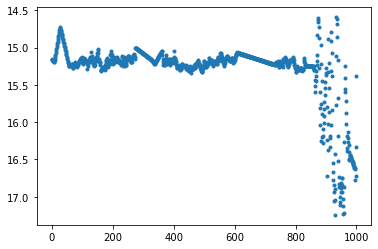

In [8]:
show = np.random.randint(0, len(X_g_int))
plt.plot(X_g_int[show], '.')
plt.gca().invert_yaxis()

### Obtain training and test sets

In [9]:
multihead = False
random_state = 1

# Get the labels as names
y_names = dataset[label_scheme].to_numpy()
# Encode the labels
enc = LabelEncoder().fit(y_names)
y_num = enc.transform(y_names)
# One hot encode the labels
y = to_categorical(y_num)

if multihead == True:

    # Train, test, split for multi-input model.
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_mulithead_1, y, test_size=0.3, random_state=random_state)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_multihead_2, y, test_size=0.3, random_state=random_state)

    # Train, validation, split for multi-input model.
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.1, random_state=random_state)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.1, random_state=random_state)

    # Single y_train, y_val, y_test for multi-input model.
    y_train = y_train1
    y_val = y_val1
    y_test = y_test1

    # # Normalise the data.
    mean1 = np.mean(X_train1)
    std1 = np.std(X_train1)
    X_train1 = (X_train1 - mean1) / std1
    X_val1 = (X_val1 - mean1) / std1
    X_test1 = (X_test1 - mean1) / std1

    mean2 = np.mean(X_train2)
    std2 = np.std(X_train2)
    X_train2 = (X_train2 - mean2) / std2
    X_val2 = (X_val2 - mean2) / std2
    X_test2 = (X_test2 - mean2) / std2

    print(f'X_train1, X_val1, X_test1 shapes: {X_train1.shape} {X_val1.shape} {X_test1.shape}')
    print(f'X_train2, X_val2, X_test2 shapes: {X_train2.shape} {X_val2.shape}, {X_test2.shape}')

elif multihead == False:
    # Train, validation, split for single-input model.
    X_train, X_test, y_train, y_test = train_test_split(X_variant, y, test_size=0.3, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=random_state)

    # Normalise the data.
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    print(f'X_train, X_val, X_test shapes: {X_train.shape} {X_val.shape} {X_test.shape}')


# Get the labels for each set as numbers.
y_train_labels = np.argmax(y_train, axis=1)

# Get the class weights for the training data.
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(zip(np.unique(y_train_labels), class_weights))


# Use over/undersampling to balance the training data.
us = 120
os = 120
# Undersample the training data
class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:us}
# Oversample the training data
class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:os,
                enc.transform(['dwarf_nova_Z_Cam'])[0]:os,
                enc.transform(['dwarf_nova_U_Gem'])[0]:os,
                enc.transform(['nova_like_VY_Scl'])[0]:os,
                enc.transform(['polar'])[0]:os,
                enc.transform(['nova_like'])[0]:os,
                enc.transform(['nova'])[0]:os,
                enc.transform(['int_polar'])[0]:os,
                enc.transform(['AMCVn'])[0]:os
                }

undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=random_state)
oversample = RandomOverSampler(sampling_strategy=class_dist_os, random_state=random_state)

if multihead == True:
    X_train1_us, y_train1_us = undersample.fit_resample(X_train1.reshape(-1, X_train1.shape[1]*X_train1.shape[2]), y_train)
    X_train1_os, y_train1_os = oversample.fit_resample(X_train1_us, y_train1_us)
    X_train1_os = X_train1_os.reshape(-1, X_train1.shape[1], X_train1.shape[2])

    X_train2_us, y_train2_us = undersample.fit_resample(X_train2.reshape(-1, X_train2.shape[1]*X_train2.shape[2]), y_train)
    X_train2_os, y_train2_os = oversample.fit_resample(X_train2_us, y_train2_us)
    X_train2_os = X_train2_os.reshape(-1, X_train2.shape[1], X_train2.shape[2])

    print(f'X_train1_os, y_train1_os shapes: {X_train1_os.shape} {y_train1_os.shape}')
    print(f'X_train2_os, y_train2_os shapes: {X_train2_os.shape} {y_train2_os.shape}')

elif multihead == False:
    X_train_us, y_train_us = undersample.fit_resample(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train)
    X_train_os, y_train_os = oversample.fit_resample(X_train_us, y_train_us)
    X_train_os = X_train_os.reshape(-1, X_train.shape[1], X_train.shape[2])

    print(f'X_train_os, y_train_os shapes: {X_train_os.shape} {y_train_os.shape}')





X_train, X_val, X_test shapes: (906, 1000, 1) (101, 1000, 1) (432, 1000, 1)
X_train_os, y_train_os shapes: (1117, 1000, 1) (1117, 10)


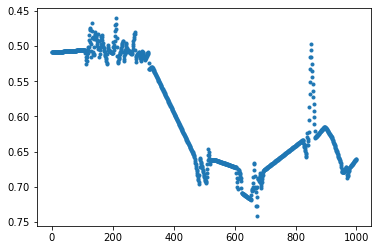

In [10]:
show = np.random.randint(0, len(X_train))
plt.plot(X_train[show], '.')
plt.gca().invert_yaxis()

### Build model function

In [19]:
def get_model(X_train, learning_rate=0.001, ks=30):
    # inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]), name="input")
    # x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(filters=32, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_1', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.00))(inputs)
    x = layers.MaxPooling1D(pool_size=2, name='MaxPool_1')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_2', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.00))(x)
    x = layers.MaxPooling1D(pool_size=2, name='MaxPool_2')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_3', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.00))(x)
    x = layers.MaxPooling1D(pool_size=2, name='MaxPool_3')(x)
    # x = layers.Conv1D(filters=64, kernel_size=ks, activation="ReLU", padding='valid', name='Conv1D_4')(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_4')(x)
    # x = layers.Conv1D(filters=64, kernel_size=ks, activation="ReLU", padding='valid', name='Conv1D_5')(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_5')(x)
    # x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten(name='Flatten')(x)
    x = layers.Dense(256, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0), name='Dense1')(x)
    x = layers.Dense(256, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0), name='Dense2')(x)
    outputs = layers.Dense(10, activation="softmax", name='Output')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    return model


def get_multiheadmodel(X_train_list, learning_rate=0.001):

    input1 = keras.Input(shape=(X_train_list[0].shape[1], X_train_list[0].shape[2]), name="input1")
    input2 = keras.Input(shape=(X_train_list[1].shape[1], X_train_list[1].shape[2]), name="input2")
    # input3 = keras.Input(shape=(X_train_list[2].shape[1], X_train_list[2].shape[2]), name="input3")

    x1 = layers.Conv1D(filters=64, kernel_size=10, activation="ReLU", padding='valid', name='i1Conv1')(input1)
    x1 = layers.MaxPooling1D(pool_size=2, name='i1MaxPool1')(x1)
    x1 = layers.Conv1D(filters=64, kernel_size=10, activation="ReLU", padding='valid', name='i1Conv12')(input1)
    x1 = layers.MaxPooling1D(pool_size=2, name='i1MaxPool2')(x1)
    x1 = layers.Flatten(name='i1Flatten')(x1)

    x2 = layers.Conv1D(filters=64, kernel_size=10, activation="ReLU", padding='valid')(input2)
    x2 = layers.MaxPooling1D(pool_size=2)(x2)
    x2 = layers.Conv1D(filters=64, kernel_size=10, activation="ReLU", padding='valid')(input2)
    x2 = layers.MaxPooling1D(pool_size=2)(x2)
    x2 = layers.Flatten()(x2)

    # x3 = layers.Conv1D(filters=64, kernel_size=10, activation="ReLU", padding='valid')(input3)
    # x3 = layers.MaxPooling1D(pool_size=2)(x3)
    # x3 = layers.Flatten()(x3)

    x = layers.Concatenate()([x1, x2])

    x = layers.Dense(100, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0))(x)
    x = layers.Dense(100, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0))(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs=[input1, input2], outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])

    return model


# model = get_model(X_train, learning_rate=0.001, ks=10)
# model = get_multiheadmodel([X_train1, X_train2])

# keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)




### Fit model

In [21]:

if multihead == True:
    X_train_final = [X_train1, X_train2]
    validation_data = ([X_val1, X_val2], y_val)
    test_data = ([X_test1, X_test2], y_test)

else:
    X_train_final = X_train
    validation_data = (X_val, y_val)
    test_data = (X_test, y_test)

# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=2)
def fit(model, x, y, validation_data, model_path, epochs=100, batch_size=32):
    callbacks= [keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",
                                                    mode='max',
                                                    patience=50,
                                                    ),
                                    ModelCheckpoint(model_path,
                                                    monitor="val_categorical_accuracy", 
                                                    mode="max",
                                                    save_best_only=True, 
                                                    verbose=0)]

    history = model.fit(x=x, 
                        y=y, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        class_weight=class_weights_dict,
                        callbacks= callbacks
            )
    
    plot_learning_curves(history, metric='categorical_accuracy')
    
    return history



def evaluate_val(x, y, validation_data, n_runs=1, multihead=True, epochs=100, batch_size=32):

    val_loss_list = []
    val_acc_list = []

    for i in range(n_runs):
        model_path = f'../results/model/NNCheckpoint{i}.hdf5'

        if multihead == True:
            model = get_multiheadmodel(x)
        else:
            model = get_model(x)
        
        history = fit(model, x, y, validation_data, model_path, epochs=epochs, batch_size=batch_size)
        best_model = load_model(model_path)
        val_loss, val_acc = best_model.evaluate(validation_data[0], validation_data[1])
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    # Print the mean and std of the validation loss and accuracy
    print(f'Validation loss: {np.mean(val_loss_list):.4f} ± {np.std(val_loss_list):.4f}')
    print(f'Validation accuracy: {np.mean(val_acc_list):.4f} ± {np.std(val_acc_list):.4f}')

    # plot a boxplot of the validation loss and accuracy
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    plt.boxplot(val_loss_list)
    plt.title("Validation loss")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.boxplot(val_acc_list)
    plt.title("Validation accuracy")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    
    # Get the index of the best model
    best_model_index = val_acc_list.index(max(val_acc_list))
    overall_best_model = load_model(f'../results/model/NNCheckpoint{best_model_index}.hdf5')

    return val_loss_list, val_acc_list, overall_best_model



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 1)]         0         
                                                                 
 Conv1D_1 (Conv1D)           (None, 1000, 32)          992       
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 500, 32)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 500, 32)           30752     
                                                                 
 MaxPool_2 (MaxPooling1D)    (None, 250, 32)           0         
                                                                 
 Conv1D_3 (Conv1D)           (None, 250, 32)           30752     
                                                                 
 MaxPool_3 (MaxPooling1D)    (None, 125, 32)           0   

Epoch 1/500
29/29 [==============================] - 1s 35ms/step - loss: 2.2721 - categorical_accuracy: 0.1015 - val_loss: 2.2266 - val_categorical_accuracy: 0.1386
Epoch 2/500
29/29 [==============================] - 1s 25ms/step - loss: 2.1987 - categorical_accuracy: 0.1126 - val_loss: 2.3804 - val_categorical_accuracy: 0.1584
Epoch 3/500
29/29 [==============================] - 1s 34ms/step - loss: 2.1082 - categorical_accuracy: 0.1225 - val_loss: 2.1827 - val_categorical_accuracy: 0.1683
Epoch 4/500
29/29 [==============================] - 1s 35ms/step - loss: 2.0543 - categorical_accuracy: 0.1291 - val_loss: 2.1597 - val_categorical_accuracy: 0.1683
Epoch 5/500
29/29 [==============================] - 1s 41ms/step - loss: 1.9986 - categorical_accuracy: 0.1347 - val_loss: 2.1042 - val_categorical_accuracy: 0.1287
Epoch 6/500
29/29 [==============================] - 1s 40ms/step - loss: 1.9751 - categorical_accuracy: 0.2230 - val_loss: 2.2933 - val_categorical_accuracy: 0.1287
Epoc

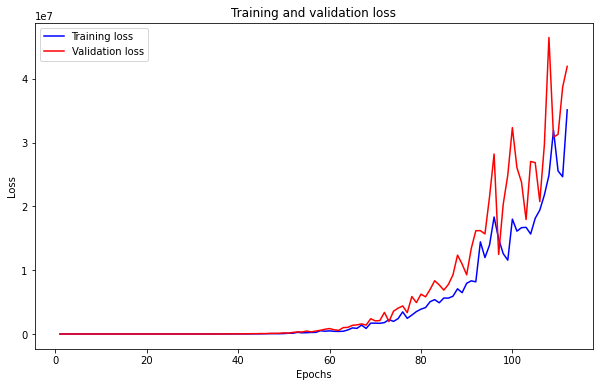

<Figure size 432x288 with 0 Axes>

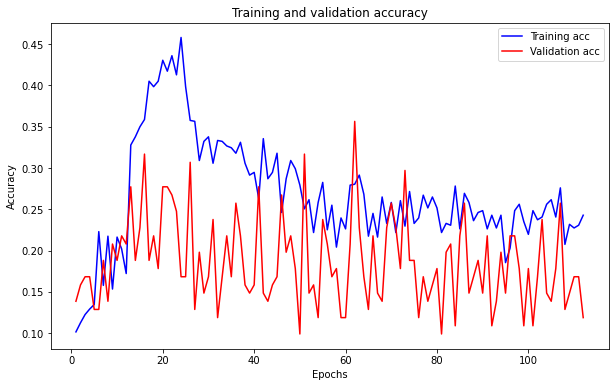

4/4 [==============================] - 0s 50ms/step - loss: 101.5900 - categorical_accuracy: 0.1386
Validation loss: 101.5900 ± 0.0000
Validation accuracy: 0.1386 ± 0.0000


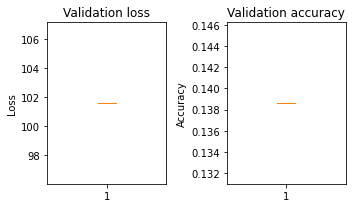

In [22]:
val_loss, val_acc, clf = evaluate_val(X_train_final,y_train,validation_data, n_runs=1, multihead=multihead, epochs=500, batch_size=32)

14/14 [==============================] - 0s 17ms/step
                   precision  recall  f1-score  support
AMCVn                   0.06    0.07      0.07       14
dwarf_nova_SU_UMa       0.75    0.02      0.03      172
dwarf_nova_U_Gem        0.17    0.51      0.25       35
dwarf_nova_WZ_Sge       0.26    0.41      0.32       17
dwarf_nova_Z_Cam        0.00    0.00      0.00       52
int_polar               0.03    0.13      0.05       15
nova                    0.11    0.14      0.12       14
nova_like               0.10    0.02      0.04       43
nova_like_VY_Scl        0.12    0.44      0.19       36
polar                   0.13    0.18      0.15       34
accuracy                0.13    0.13      0.13        0
macro avg               0.17    0.19      0.12      432
weighted avg            0.36    0.13      0.09      432


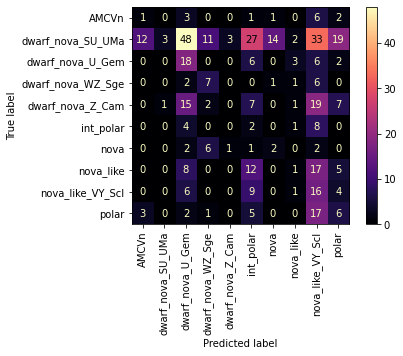

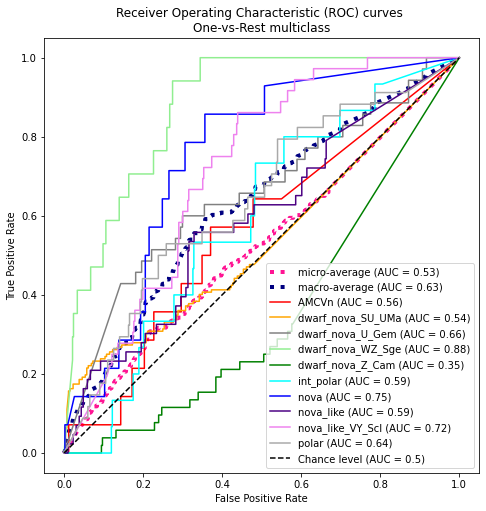

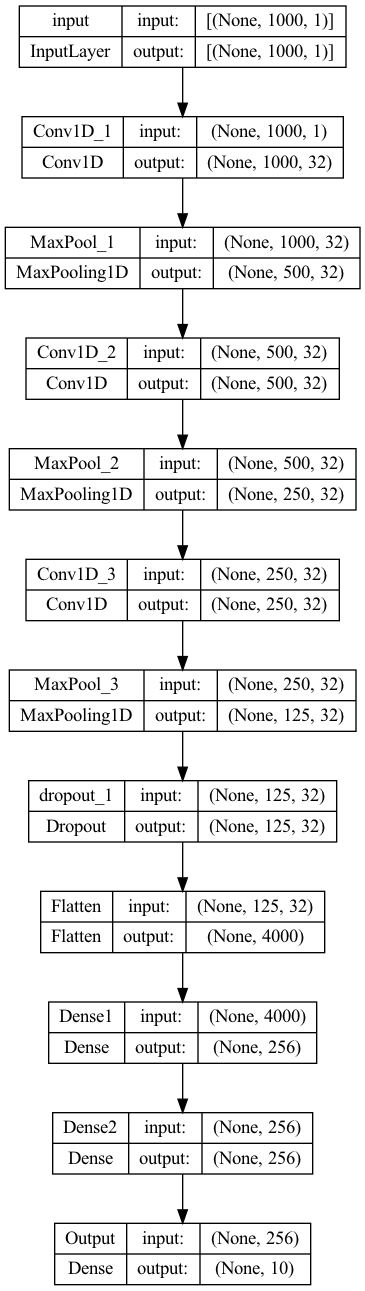

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test='_test'
description = 'test'
# Store best parameters and best model in variables.
# best_model = load_model(f'../results/model/NNCheckpoint1.hdf5')
best_model = clf

# # Get the labels as names
# y_names = dataset[label_scheme].to_numpy()
# # Encode the labels
# enc = LabelEncoder().fit(y_names)
# y_num = enc.transform(y_names)
# # One hot encode the labels
# y = to_categorical(y_num)

# Collect unique class labels in order of y_test.
y_test_labels = np.argmax(y_test, axis=1)
class_labels = enc.inverse_transform(np.unique(y_test_labels))

# Make predictions and gather probabilities for applying model to test set.

y_pred_prob = best_model.predict(test_data[0])
y_pred = np.argmax(y_pred_prob, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma')
disp.figure_.savefig(f'../results/1dcnn/cm/cm_{description}{test}.pdf', format='pdf', bbox_inches='tight')


# Print and save the classification report
pd.options.display.max_rows=None
cr = classification_report(y_test_labels, y_pred, target_names=enc.inverse_transform(np.unique(y_train_labels)), output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
cr_df.to_csv(f'../results/1dcnn/cr/cr_{description}{test}.csv')
print(cr_df)

plot_roc(y_train_labels, y_test_labels, y_pred_prob, enc, path=f'../results/1dcnn/roc_curve/{description}{test}.pdf')

clf.save(f'../results/1dcnn/model/{description}{test}.h5')

keras.utils.plot_model(clf, to_file='model_plot.png', show_shapes=True, show_layer_names=True)